# 2.Data acquaintance and Pre-processing

## importing the needed libraries

In [1]:
import psycopg2
import psycopg2.extras
import pandas as pd
import numpy
import shapely


import geopandas as gpd
import numpy as np

import helper
import calendar
import os, sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style


In [2]:
PLT_FIG_WIDTH = 7
PLT_FIG_HEIGHT = 3

In [8]:
sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents', 'DataStories-UniPi', 'MovinPy'))
import cleanse_and_detect_outliers
from cleanse_and_detect_outliers import cleanse

## Connect to the Postgres DB in order to acquire the raw data

In [3]:
con = psycopg2.connect(database='gis_project',  
                       user='????',     
                       password='????',  
                       host='????',  
                       port=5432)

In [ ]:
sql_query = 'SELECT * FROM unipi_ais_feb_mar_2018_raw;'
geo_df = gpd.GeoDataFrame.from_postgis(sql_query, con, geom_col='geom')

In [7]:
geo_df.sort_values('timestmp', inplace=True)#sort data by timestamp

In [13]:
geo_df.head()

,mmsi,timestmp,geom,lon,lat,velocity,ais_type,ais_status,ais_heading,ais_turn,ais_course
160691,319092600,1517436000000,POINT (23.64761 37.93285),23.647613,37.932847,0.0,NaN,NaN,135.0,NaN,NaN
160690,237017200,1517436000000,POINT (23.56900 37.95528),23.568995,37.955283,0.0,NaN,NaN,NaN,NaN,NaN
160692,235100119,1517436001000,POINT (23.68193 37.93263),23.681927,37.932628,0.0,NaN,NaN,242.0,NaN,NaN
160693,237008100,1517436002000,POINT (23.64102 37.94490),23.641023,37.944897,0.0,NaN,NaN,NaN,NaN,NaN
99,239864200,1517436004000,POINT (23.61501 37.94470),23.615015,37.944697,0.0,NaN,NaN,NaN,NaN,NaN


## 2.1 Clean the noise 

In [10]:
def data_preprocessing(geo_df2):
    geo_df2.drop_duplicates(subset=['mmsi','timestmp'], inplace=True)#drop duplicates
    geo_df2.dropna(subset=['mmsi', 'timestmp','speed'], inplace=True) #drop nan values
    geo_df2=geo_df2.loc[geo_df2.speed < 50].copy() #drop values where the speed surpasses the 50 knots threshold
     #Converting time from msec. to sec.
    geo_df2.loc[:, 'timestamp_sec'] = geo_df2.timestmp/10**3
    geo_df2=geo_df2.rename(columns={'speed':'velocity'})
# Calculate acceleration
   # geo_df2 = geo_df2.groupby('mmsi', group_keys=False).apply(lambda gdf: helper.calculate_acceleration(gdf, ts_column='timestamp_sec'))
    return geo_df2

In [ ]:
final_geodf=data_preprocessing(geo_df)

### Or clean the noise using MovinPy's cleanse which also detects the outliers

In [ ]:
#geo_df=geo_df.rename(columns={'timestmp':'ts','mmsi':'oid','speed':'velocity'})
#geo_df.loc[:, 'timestamp_sec'] = geo_df.ts/10**3
#geo_df=geo_df[['oid','ts','geom','lon','lat','velocity','acceleration']]
#geo_df = geo_df.groupby('oid', group_keys=False).apply(lambda gdf: helper.calculate_acceleration(gdf, ts_column='timestamp_sec'))
#clean_gdf=cleanse(geo_df)
#len(clean_gdf)

In [25]:
len(final_geodf)

3980150

# 3.2 Sampling Rate

## Calculating the sampling rate by weekday.

In [18]:
total_records_per_wd = final_geodf.groupby([pd.to_datetime(final_geodf.timestmp, unit="ms").dt.date]).apply(len).to_frame().reset_index()
total_records_per_wd.loc[:, 'day_name'] = pd.to_datetime(total_records_per_wd.timestmp).dt.day_name()
total_records_per_wd.loc[:, 'day_name'] = pd.Categorical(total_records_per_wd.day_name, categories=list(calendar.day_name), ordered=True)
total_records_per_wd.sort_values('day_name', inplace=True)
total_records_per_wd=total_records_per_wd.groupby(total_records_per_wd.day_name).apply(sum)

## Plot the results

Text(0, 0.5, 'Number of records x 10000')

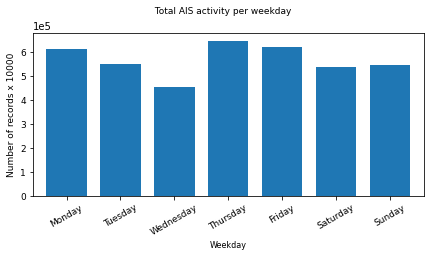

In [19]:
total_records_per_wd.plot.bar(cmap='tab20', figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=9, width=0.75, legend=False, rot=30)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r' Total AIS activity per weekday', fontsize=9, y=1)
plt.xlabel(r'Weekday', fontsize=8)
plt.ylabel(r'Number of records x 10000', fontsize=9)

## Calculate the  average sampling rate per weekday

In [21]:
avg_records_per_wd = final_geodf.groupby([pd.to_datetime(final_geodf.timestmp, unit="ms").dt.date]).apply(len).to_frame().reset_index()
avg_records_per_wd.loc[:, 'day_name'] = pd.to_datetime(avg_records_per_wd.timestmp).dt.day_name()
avg_records_per_wd.loc[:, 'day_name'] = pd.Categorical(avg_records_per_wd.day_name, categories=list(calendar.day_name), ordered=True)
avg_records_per_wd.sort_values('day_name', inplace=True)

avg_records_per_wd=avg_records_per_wd.groupby(avg_records_per_wd.day_name).apply(lambda x: x.sum()/len(x))

## Plot the results

Text(0, 0.5, 'number of records x 10000')

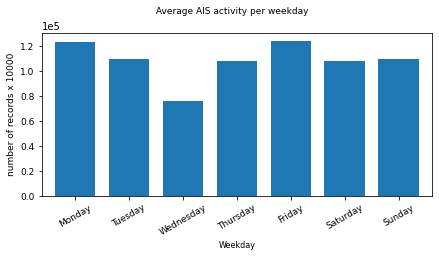

In [22]:
avg_records_per_wd.plot.bar(cmap='tab20', figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=9, width=0.75, legend=False, rot=30)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r' Average AIS activity per weekday', fontsize=9, y=1)
plt.xlabel(r'Weekday', fontsize=8)
plt.ylabel(r'number of records x 10000', fontsize=9)

# 2.3 Calculating the acceleration rate and plotting the result

Text(0, 0.5, '#records')

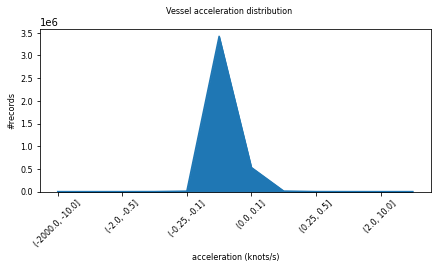

In [23]:
no_of_bins=[-2000, -10, -2, -0.5, -0.25, -0.1, 0, 0.1, 0.25, 0.5, 2, 10, 2000] 

out = pd.cut(final_geodf.acceleration, no_of_bins)
ax = out.value_counts(sort=False).plot.area(figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=8, cmap='tab20', rot=45)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle(r'Vessel acceleration distribution', fontsize=8)
plt.xlabel(r'acceleration (knots/s)', fontsize=8)
plt.ylabel(r'#records', fontsize=8)

Text(0, 0.5, '#recordsx10000')

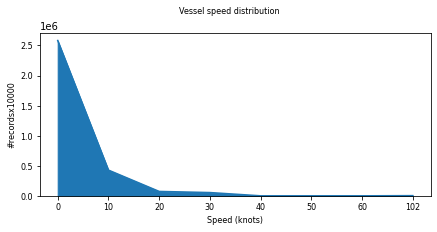

In [15]:
out = pd.cut(final_geodf.velocity, [0, 10, 20, 30, 40, 50, 60, np.round(final_geodf.velocity.max()), np.round(final_geodf.velocity.max())+2])
ax = out.value_counts(sort=False).plot.area(figsize=(PLT_FIG_WIDTH,PLT_FIG_HEIGHT), fontsize=8, cmap='tab20', rot=0)
ax.set_xticklabels([''] + out.cat.categories.left.values.astype(int).tolist() + [''])

plt.suptitle(r'Vessel speed distribution', fontsize=8, y=1)
plt.xlabel(r'Speed (knots)', fontsize=8)
plt.ylabel(r'#recordsx10000', fontsize=8)

## Save the cleaned data to a new csv file

In [ ]:
final_geodf.to_csv('./unipi_ais_feb_mar_2018_clean.csv', header=True, index=False ,sep=';')